# 🎯 YOLO11 고급 객체 검출 시스템 완벽 가이드

## 📚 이 노트북에서 배우는 내용
1. **YOLO11 기본 이해**: 모델 구조와 동작 원리
2. **고급 검출 기법**: 앙상블, 세그멘테이션
3. **도메인 특화 검출**: 실무 응용 사례
4. **성능 최적화**: 속도와 정확도 개선
5. **실전 프로젝트**: 완성된 시스템 구축

**작성자**: aebonlee  
**날짜**: 2024.11.21  
**GitHub**: [YOLO11_study](https://github.com/aebonlee/YOLO11_study)

## 📦 Part 1: 환경 설정 및 라이브러리

### 필수 패키지 설치
먼저 필요한 모든 패키지를 설치합니다.

In [1]:
# 필수 패키지 설치 (처음 한 번만 실행)
# GPU 지원을 원하면 pytorch 공식 사이트에서 CUDA 버전 확인 후 설치

!pip install ultralytics>=8.3.0  # YOLO11 공식 라이브러리
!pip install opencv-python>=4.8.0  # 컴퓨터 비전 라이브러리
!pip install matplotlib>=3.6.0  # 시각화
!pip install numpy>=1.24.0  # 수치 연산
!pip install pandas>=2.0.0  # 데이터 분석
!pip install scikit-learn>=1.3.0  # 머신러닝 도구
!pip install scipy>=1.10.0  # 과학 계산
!pip install seaborn>=0.12.0  # 고급 시각화
!pip install tqdm>=4.65.0  # 진행 표시줄

In [2]:
# 라이브러리 임포트
# 각 라이브러리의 역할을 이해하는 것이 중요합니다

import cv2  # OpenCV: 이미지/비디오 처리
import numpy as np  # NumPy: 배열 연산
from ultralytics import YOLO  # YOLO 모델
import torch  # PyTorch: 딥러닝 프레임워크
import matplotlib.pyplot as plt  # 그래프 그리기
from matplotlib.patches import Rectangle, Circle, Polygon  # 도형 그리기
import matplotlib.patches as mpatches  # 범례용 패치
from pathlib import Path  # 파일 경로 처리
import json  # JSON 데이터 처리
import time  # 시간 측정
import os  # 운영체제 인터페이스
from typing import List, Dict, Tuple, Optional  # 타입 힌팅
import pandas as pd  # 데이터프레임
import seaborn as sns  # 시각화 스타일
from tqdm import tqdm  # 진행률 표시
from sklearn.cluster import DBSCAN  # 클러스터링
from scipy.spatial import distance  # 거리 계산
from collections import defaultdict  # 기본값 딕셔너리
import warnings
warnings.filterwarnings('ignore')  # 경고 메시지 숨기기

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 모든 라이브러리가 성공적으로 임포트되었습니다!")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ 모든 라이브러리가 성공적으로 임포트되었습니다!
PyTorch 버전: 2.8.0+cu126
CUDA 사용 가능: True
CUDA 버전: 12.6
GPU 이름: Tesla T4


## 🎓 Part 2: YOLO11 기본 이해

### YOLO (You Only Look Once) 란?
- **실시간 객체 검출** 알고리즘
- 이미지를 **한 번만** 보고 객체 검출
- **바운딩 박스**와 **클래스 확률**을 동시에 예측

### YOLO11 모델 종류
| 모델 | 크기 | 속도 | 정확도 | 용도 |
|------|------|------|--------|------|
| YOLOv11n | 3.2M | 매우 빠름 | 보통 | 실시간, 모바일 |
| YOLOv11s | 11.2M | 빠름 | 좋음 | 일반 용도 |
| YOLOv11m | 25.9M | 보통 | 높음 | 균형잡힌 성능 |
| YOLOv11l | 43.7M | 느림 | 매우 높음 | 정확도 우선 |
| YOLOv11x | 68.2M | 매우 느림 | 최고 | 최고 정확도 |

In [3]:
# YOLO 모델 로딩 예제
# 처음 실행시 모델이 자동으로 다운로드됩니다

def load_yolo_model(model_name='yolo11n.pt'):
    """
    YOLO 모델을 로드하는 함수

    Parameters:
    -----------
    model_name : str
        모델 파일명 (yolo11n.pt, yolo11s.pt, yolo11m.pt, yolo11l.pt, yolo11x.pt)

    Returns:
    --------
    model : YOLO
        로드된 YOLO 모델 객체
    """
    print(f"🔄 {model_name} 모델 로딩 중...")

    try:
        # YOLO 모델 생성
        model = YOLO(model_name)

        # 모델 정보 출력
        print(f"✅ 모델 로드 완료: {model_name}")

        # GPU 사용 설정
        if torch.cuda.is_available():
            model.to('cuda')
            print("🚀 GPU 모드로 실행")
        else:
            print("💻 CPU 모드로 실행")

        return model

    except Exception as e:
        print(f"❌ 모델 로딩 실패: {e}")
        return None

# 테스트: nano 모델 로드
model_nano = load_yolo_model('yolo11n.pt')

# 모델이 검출할 수 있는 클래스 확인
if model_nano:
    print(f"\n📋 검출 가능한 클래스 수: {len(model_nano.names)}")
    print("예시 클래스:")
    for i, name in list(model_nano.names.items())[:10]:  # 처음 10개만
        print(f"  {i}: {name}")

🔄 yolo11n.pt 모델 로딩 중...
✅ 모델 로드 완료: yolo11n.pt
🚀 GPU 모드로 실행

📋 검출 가능한 클래스 수: 80
예시 클래스:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light


## 🖼️ Part 3: 기본 객체 검출

### 샘플 이미지로 첫 검출 수행하기

📥 다운로드 중: bus.jpg
✅ 다운로드 완료: bus.jpg
📥 다운로드 중: hot-ballon.jpeg
✅ 다운로드 완료: hot-ballon.jpeg


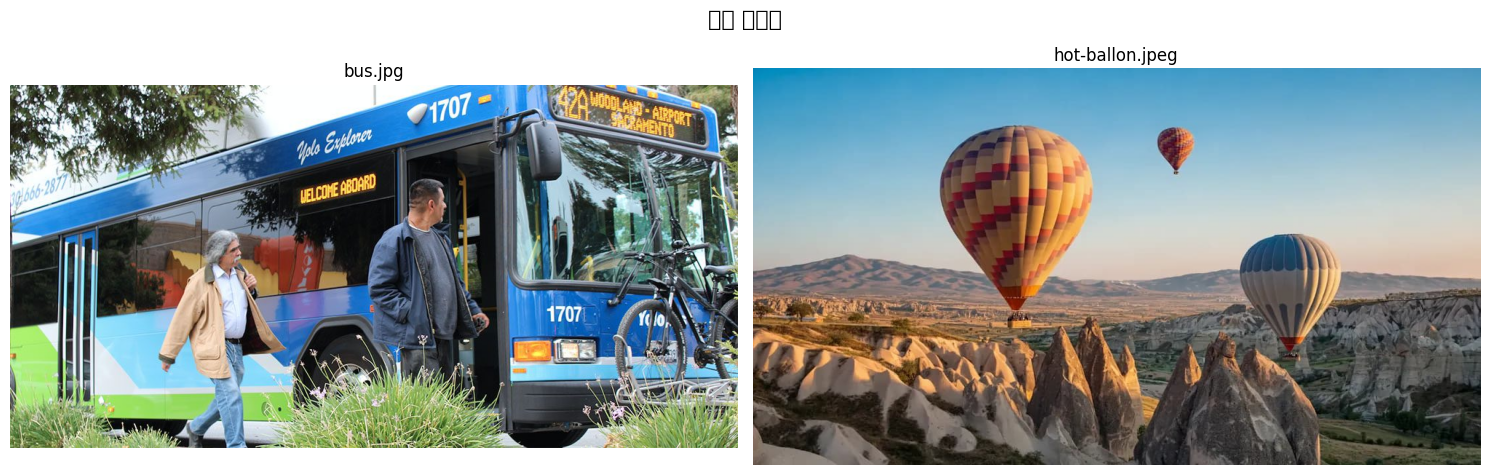

In [5]:
# 샘플 이미지 다운로드 함수
import urllib.request

def download_sample_images():
    """
    테스트용 샘플 이미지를 다운로드합니다.
    Ultralytics 공식 샘플 이미지를 사용합니다.
    """
    # 샘플 이미지 URL과 저장할 파일명
    samples = [
        ("https://www.transdev.com/wp-content/uploads/2020/03/yolo-hero-x.jpg", "bus.jpg"),
        ("https://discuss.pytorch.kr/uploads/default/original/2X/e/e9fd2722c675bd14bc1a19c777a3352a3d42d261.jpeg", "hot-ballon.jpeg"),
    ]

    # test_images 폴더 생성
    os.makedirs("test_images", exist_ok=True)

    downloaded = []
    for url, filename in samples:
        filepath = f"test_images/{filename}"

        if not os.path.exists(filepath):
            print(f"📥 다운로드 중: {filename}")
            try:
                urllib.request.urlretrieve(url, filepath)
                print(f"✅ 다운로드 완료: {filename}")
            except Exception as e:
                print(f"❌ 다운로드 실패: {filename} - {e}")
                continue
        else:
            print(f"✓ 이미 존재: {filename}")

        downloaded.append(filepath)

    return downloaded

# 샘플 이미지 다운로드
sample_images = download_sample_images()

# 이미지 표시
if sample_images:
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    if len(sample_images) == 1:
        axes = [axes]

    for ax, img_path in zip(axes, sample_images):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(Path(img_path).name)
        ax.axis('off')

    plt.suptitle("샘플 이미지", fontsize=16)
    plt.tight_layout()
    plt.show()

🔍 기본 객체 검출 수행...


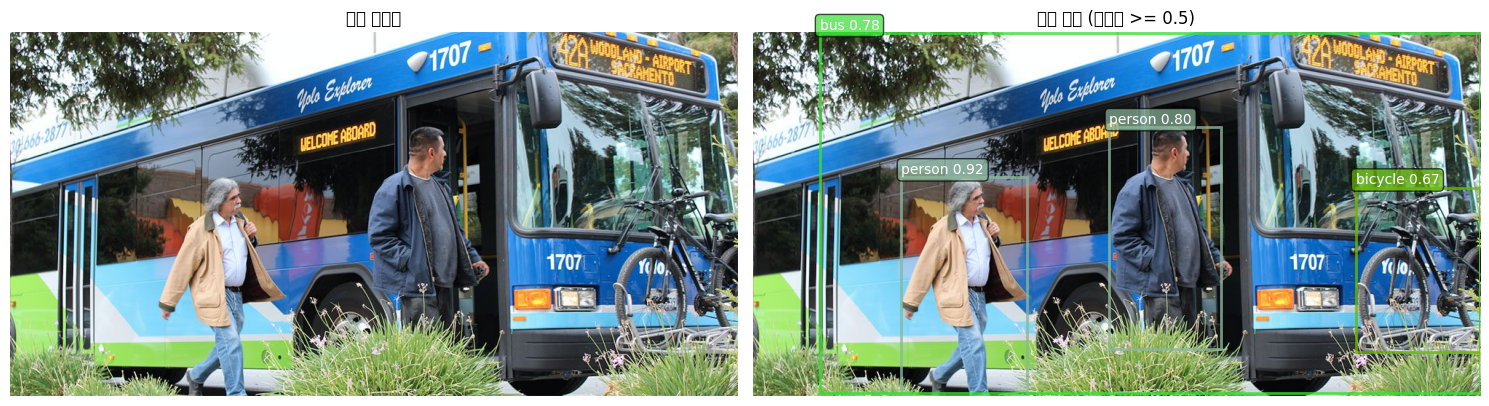


📊 검출 통계:
총 검출 객체 수: 4

클래스별 검출 수:
  • person: 2개
  • bus: 1개
  • bicycle: 1개


In [6]:
def basic_detection(model, image_path, conf_threshold=0.5):
    """
    기본 객체 검출을 수행하는 함수

    Parameters:
    -----------
    model : YOLO
        YOLO 모델 객체
    image_path : str
        검출할 이미지 경로
    conf_threshold : float
        신뢰도 임계값 (0~1)

    Returns:
    --------
    results : list
        검출 결과 리스트
    """
    # 이미지 읽기
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 검출 수행
    # verbose=False: 출력 메시지 숨기기
    # conf: 최소 신뢰도 설정
    results = model(image_path, conf=conf_threshold, verbose=False)

    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # 원본 이미지
    ax1.imshow(image_rgb)
    ax1.set_title("원본 이미지")
    ax1.axis('off')

    # 검출 결과
    ax2.imshow(image_rgb)
    ax2.set_title(f"검출 결과 (신뢰도 >= {conf_threshold})")
    ax2.axis('off')

    # 검출된 객체 정보 저장
    detections = []

    # 결과 처리
    for r in results:
        if r.boxes is not None:  # 검출된 객체가 있는 경우
            boxes = r.boxes

            for i, box in enumerate(boxes):
                # 바운딩 박스 좌표 (x1, y1, x2, y2)
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

                # 클래스 ID와 이름
                cls_id = int(box.cls[0])
                cls_name = model.names[cls_id]

                # 신뢰도
                confidence = float(box.conf[0])

                # 색상 설정 (클래스별 다른 색상)
                np.random.seed(cls_id)  # 같은 클래스는 같은 색상
                color = np.random.rand(3)

                # 바운딩 박스 그리기
                rect = Rectangle((x1, y1), x2-x1, y2-y1,
                               linewidth=2, edgecolor=color,
                               facecolor='none', alpha=0.8)
                ax2.add_patch(rect)

                # 라벨 추가
                label = f"{cls_name} {confidence:.2f}"
                ax2.text(x1, y1-5, label, fontsize=10,
                        color='white', backgroundcolor=color,
                        bbox=dict(boxstyle="round,pad=0.3",
                                facecolor=color, alpha=0.7))

                # 검출 정보 저장
                detections.append({
                    'class': cls_name,
                    'confidence': confidence,
                    'bbox': [x1, y1, x2, y2]
                })

    plt.tight_layout()
    plt.show()

    # 검출 통계 출력
    print(f"\n📊 검출 통계:")
    print(f"총 검출 객체 수: {len(detections)}")

    if detections:
        # 클래스별 개수
        class_counts = {}
        for det in detections:
            cls = det['class']
            class_counts[cls] = class_counts.get(cls, 0) + 1

        print("\n클래스별 검출 수:")
        for cls, count in class_counts.items():
            print(f"  • {cls}: {count}개")

    return detections

# 기본 검출 테스트
if sample_images and model_nano:
    print("🔍 기본 객체 검출 수행...")
    detections = basic_detection(model_nano, sample_images[0], conf_threshold=0.5)

## 🚀 Part 4: 고급 검출 기법 - 앙상블

### 앙상블(Ensemble) 기법이란?
- **여러 모델의 예측을 결합**하여 정확도 향상
- 각 모델의 장점을 활용
- 오탐지(False Positive) 감소

In [7]:
class EnsembleDetector:
    """
    여러 YOLO 모델을 앙상블하여 검출 성능을 향상시키는 클래스

    앙상블 전략:
    1. 여러 모델로 독립적으로 검출
    2. 각 검출 결과의 신뢰도를 가중치로 사용
    3. IoU 기반으로 같은 객체 판별
    4. 투표(Voting) 또는 평균으로 최종 결정
    """

    def __init__(self, model_configs):
        """
        Parameters:
        -----------
        model_configs : list
            [(model_name, weight), ...] 형태의 리스트
            예: [('yolo11n.pt', 0.3), ('yolo11s.pt', 0.3), ('yolo11m.pt', 0.4)]
        """
        self.models = []
        self.weights = []

        print("🔧 앙상블 검출기 초기화...")

        for model_name, weight in model_configs:
            print(f"  • {model_name} 로딩 (가중치: {weight})")
            model = YOLO(model_name)
            self.models.append(model)
            self.weights.append(weight)

        # 가중치 정규화 (합이 1이 되도록)
        total_weight = sum(self.weights)
        self.weights = [w / total_weight for w in self.weights]

        print(f"✅ {len(self.models)}개 모델로 앙상블 준비 완료")

    def calculate_iou(self, box1, box2):
        """
        두 바운딩 박스의 IoU(Intersection over Union) 계산

        IoU = 교집합 영역 / 합집합 영역
        """
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        # 교집합 영역
        intersection = max(0, x2 - x1) * max(0, y2 - y1)

        # 각 박스의 영역
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

        # 합집합 영역
        union = area1 + area2 - intersection

        # IoU 계산
        iou = intersection / union if union > 0 else 0

        return iou

    def ensemble_detect(self, image_path, conf_threshold=0.4, iou_threshold=0.5):
        """
        앙상블 검출 수행

        Parameters:
        -----------
        image_path : str
            이미지 경로
        conf_threshold : float
            최소 신뢰도
        iou_threshold : float
            같은 객체로 판단할 IoU 임계값
        """
        all_detections = []

        # 각 모델로 검출 수행
        for model, weight in zip(self.models, self.weights):
            results = model(image_path, conf=conf_threshold, verbose=False)

            for r in results:
                if r.boxes is not None:
                    for box in r.boxes:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        cls_id = int(box.cls[0])
                        conf = float(box.conf[0])

                        all_detections.append({
                            'bbox': [x1, y1, x2, y2],
                            'class': model.names[cls_id],
                            'class_id': cls_id,
                            'confidence': conf * weight,  # 가중치 적용
                            'weight': weight
                        })

        # 앙상블 결과 통합
        ensemble_results = self._merge_detections(all_detections, iou_threshold)

        return ensemble_results

    def _merge_detections(self, detections, iou_threshold=0.5):
        """
        중복 검출 결과를 통합
        """
        if not detections:
            return []

        # 신뢰도 순으로 정렬
        detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)

        merged = []
        used = [False] * len(detections)

        for i, det1 in enumerate(detections):
            if used[i]:
                continue

            # 같은 객체로 판단되는 검출들 그룹화
            group = [det1]
            used[i] = True

            for j, det2 in enumerate(detections[i+1:], i+1):
                if used[j]:
                    continue

                # 같은 클래스이고 IoU가 임계값 이상이면 같은 객체
                if (det1['class'] == det2['class'] and
                    self.calculate_iou(det1['bbox'], det2['bbox']) > iou_threshold):
                    group.append(det2)
                    used[j] = True

            # 그룹의 평균으로 최종 검출 생성
            if len(group) >= len(self.models) // 2:  # 과반수 이상이 검출한 경우만
                avg_bbox = np.mean([d['bbox'] for d in group], axis=0)
                avg_conf = np.mean([d['confidence'] for d in group])

                merged.append({
                    'bbox': avg_bbox.tolist(),
                    'class': group[0]['class'],
                    'confidence': avg_conf,
                    'votes': len(group)  # 몇 개 모델이 검출했는지
                })

        return merged

# 앙상블 검출기 생성 및 테스트
print("\n🎯 앙상블 검출 테스트")

# 3개 모델로 앙상블 구성
ensemble_configs = [
    ('yolo11n.pt', 0.2),  # Nano - 빠르지만 정확도 낮음
    ('yolo11s.pt', 0.3),  # Small - 균형
    ('yolo11m.pt', 0.5),  # Medium - 정확도 높음
]

ensemble = EnsembleDetector(ensemble_configs)

if sample_images:
    # 앙상블 검출 수행
    ensemble_results = ensemble.ensemble_detect(sample_images[0])

    print(f"\n📊 앙상블 검출 결과:")
    print(f"검출된 객체 수: {len(ensemble_results)}")

    for i, det in enumerate(ensemble_results):
        print(f"\n객체 {i+1}:")
        print(f"  클래스: {det['class']}")
        print(f"  신뢰도: {det['confidence']:.3f}")
        print(f"  투표 수: {det['votes']}/{len(ensemble.models)} 모델")


🎯 앙상블 검출 테스트
🔧 앙상블 검출기 초기화...
  • yolo11n.pt 로딩 (가중치: 0.2)
  • yolo11s.pt 로딩 (가중치: 0.3)
  • yolo11m.pt 로딩 (가중치: 0.5)
✅ 3개 모델로 앙상블 준비 완료

📊 앙상블 검출 결과:
검출된 객체 수: 5

객체 1:
  클래스: person
  신뢰도: 0.302
  투표 수: 3/3 모델

객체 2:
  클래스: bus
  신뢰도: 0.241
  투표 수: 4/3 모델

객체 3:
  클래스: person
  신뢰도: 0.288
  투표 수: 3/3 모델

객체 4:
  클래스: bicycle
  신뢰도: 0.269
  투표 수: 3/3 모델

객체 5:
  클래스: handbag
  신뢰도: 0.351
  투표 수: 1/3 모델


## 🎨 Part 5: 세그멘테이션 (Segmentation)

### 세그멘테이션이란?
- **픽셀 단위**로 객체를 분류
- 바운딩 박스보다 **정확한 윤곽선** 제공
- 의료 영상, 자율주행 등에 활용


🎨 세그멘테이션 검출 테스트
🎨 세그멘테이션 모델 로딩: yolo11n-seg.pt
✅ 세그멘테이션 모델 준비 완료


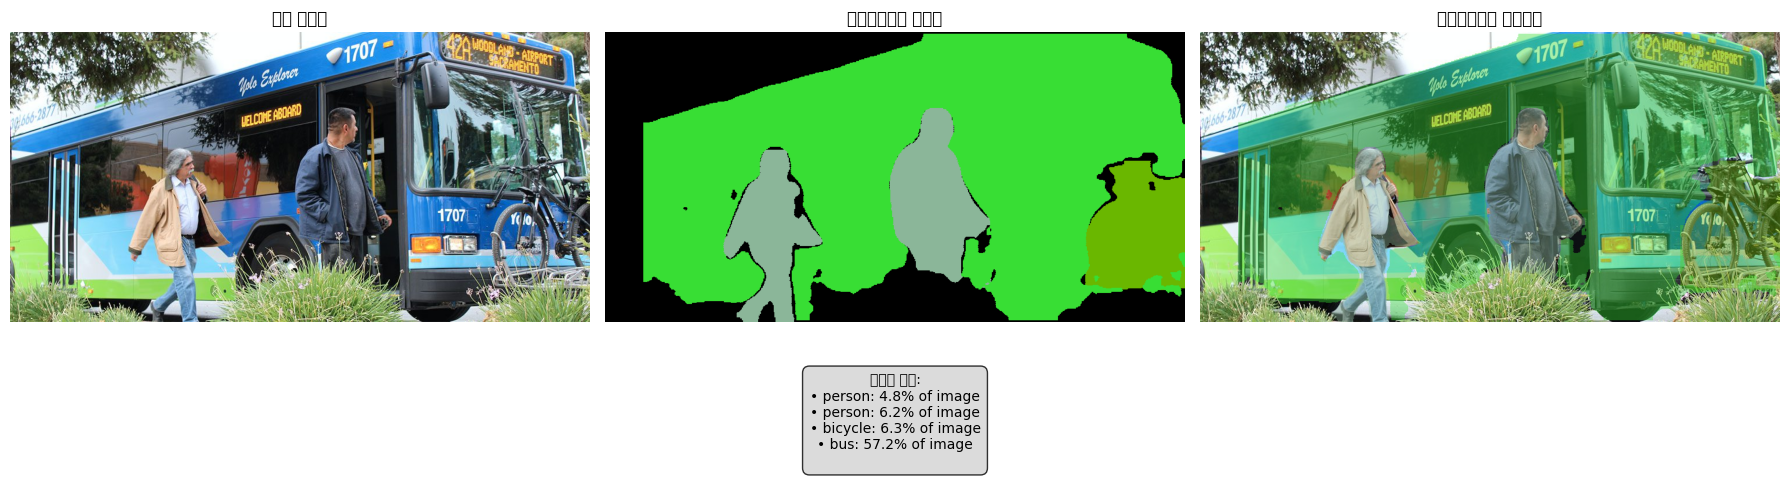


📊 세그멘테이션 결과:

객체 1:
  클래스: person
  신뢰도: 0.858
  영역: 4.83% of image

객체 2:
  클래스: person
  신뢰도: 0.819
  영역: 6.23% of image

객체 3:
  클래스: bicycle
  신뢰도: 0.729
  영역: 6.30% of image

객체 4:
  클래스: bus
  신뢰도: 0.647
  영역: 57.20% of image


In [8]:
class SegmentationDetector:
    """
    YOLO 세그멘테이션 모델을 사용한 정밀 객체 검출
    """

    def __init__(self, model_name='yolo11n-seg.pt'):
        """
        세그멘테이션 모델 초기화
        -seg 접미사가 붙은 모델 사용
        """
        print(f"🎨 세그멘테이션 모델 로딩: {model_name}")
        self.model = YOLO(model_name)
        print("✅ 세그멘테이션 모델 준비 완료")

    def segment_image(self, image_path, conf_threshold=0.5):
        """
        이미지 세그멘테이션 수행
        """
        # 이미지 읽기
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image_rgb.shape[:2]

        # 세그멘테이션 수행
        results = self.model(image_path, conf=conf_threshold, verbose=False)

        # 결과 시각화를 위한 마스크 이미지 생성
        mask_image = np.zeros_like(image_rgb)
        overlay_image = image_rgb.copy()

        # 검출 정보 저장
        segmentation_results = []

        for r in results:
            if r.masks is not None:  # 마스크가 있는 경우
                masks = r.masks.data.cpu().numpy()
                boxes = r.boxes

                for i, (mask, box) in enumerate(zip(masks, boxes)):
                    # 클래스 정보
                    cls_id = int(box.cls[0])
                    cls_name = self.model.names[cls_id]
                    confidence = float(box.conf[0])

                    # 색상 생성 (클래스별 고유 색상)
                    np.random.seed(cls_id)
                    color = (np.random.rand(3) * 255).astype(int)

                    # 마스크 리사이즈
                    mask_resized = cv2.resize(mask, (w, h))

                    # 마스크 적용
                    mask_bool = mask_resized > 0.5
                    mask_image[mask_bool] = color

                    # 오버레이 생성 (반투명)
                    alpha = 0.4
                    overlay_image[mask_bool] = (
                        overlay_image[mask_bool] * (1 - alpha) +
                        color * alpha
                    ).astype(np.uint8)

                    # 마스크 면적 계산
                    area = np.sum(mask_bool)
                    area_percentage = (area / (w * h)) * 100

                    segmentation_results.append({
                        'class': cls_name,
                        'confidence': confidence,
                        'area_pixels': area,
                        'area_percentage': area_percentage
                    })

        # 시각화
        self._visualize_segmentation(image_rgb, mask_image, overlay_image,
                                    segmentation_results)

        return segmentation_results

    def _visualize_segmentation(self, original, mask, overlay, results):
        """
        세그멘테이션 결과 시각화
        """
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 원본 이미지
        axes[0].imshow(original)
        axes[0].set_title("원본 이미지")
        axes[0].axis('off')

        # 세그멘테이션 마스크
        axes[1].imshow(mask)
        axes[1].set_title("세그멘테이션 마스크")
        axes[1].axis('off')

        # 오버레이 이미지
        axes[2].imshow(overlay)
        axes[2].set_title("세그멘테이션 오버레이")
        axes[2].axis('off')

        # 정보 텍스트 추가
        info_text = "검출된 객체:\n"
        for r in results:
            info_text += f"• {r['class']}: {r['area_percentage']:.1f}% of image\n"

        fig.text(0.5, 0.02, info_text, ha='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.5",
                         facecolor='lightgray', alpha=0.8))

        plt.tight_layout()
        plt.show()

# 세그멘테이션 테스트
print("\n🎨 세그멘테이션 검출 테스트")

seg_detector = SegmentationDetector('yolo11n-seg.pt')

if sample_images:
    seg_results = seg_detector.segment_image(sample_images[0])

    print("\n📊 세그멘테이션 결과:")
    for i, result in enumerate(seg_results):
        print(f"\n객체 {i+1}:")
        print(f"  클래스: {result['class']}")
        print(f"  신뢰도: {result['confidence']:.3f}")
        print(f"  영역: {result['area_percentage']:.2f}% of image")

## 🏢 Part 6: 도메인 특화 검출

### 실무 응용 사례
특정 분야에 최적화된 검출 시스템 구축


🏢 도메인 특화 검출 테스트
🏢 도메인 특화 검출기 초기화: traffic
   모니터링 클래스: person, car, bus, truck, bicycle...

🚗 교통 도메인 분석:


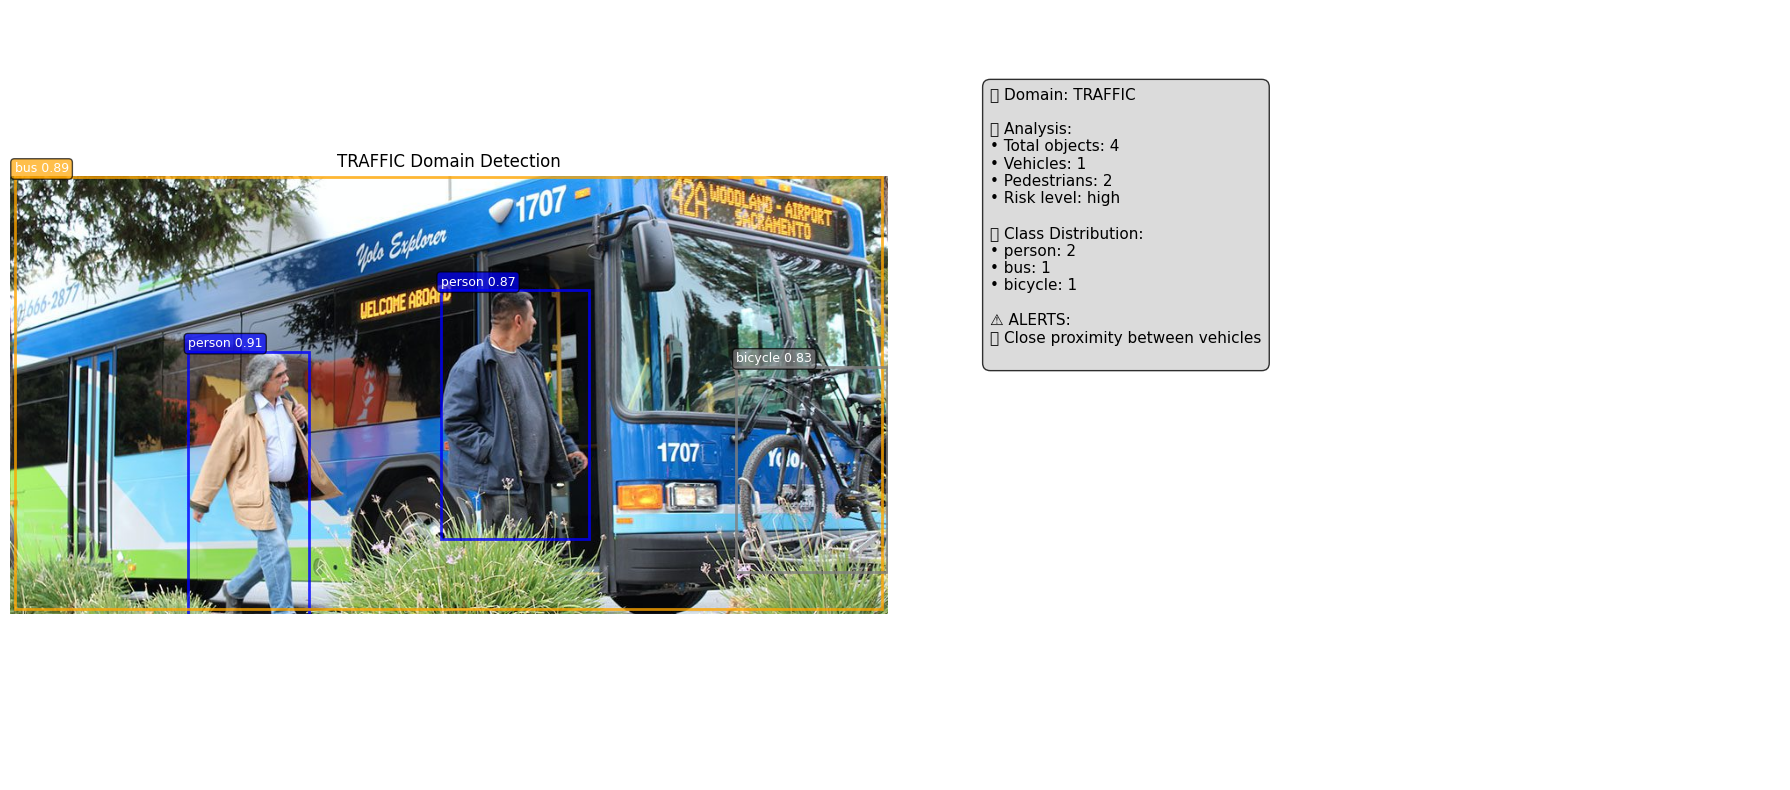

검출된 관련 객체: 4
생성된 알람: 1개


In [9]:
class DomainSpecificDetector:
    """
    도메인별 특화 검출 시스템
    실제 비즈니스 요구사항에 맞춰 커스터마이즈
    """

    # 도메인별 중요 클래스 정의
    DOMAINS = {
        'traffic': {
            'classes': ['person', 'car', 'bus', 'truck', 'bicycle',
                       'motorcycle', 'traffic light', 'stop sign'],
            'alerts': {
                'jaywalking': 'Person detected in vehicle lane',
                'congestion': 'High vehicle density detected',
                'accident_risk': 'Close proximity between vehicles'
            }
        },
        'retail': {
            'classes': ['person', 'handbag', 'backpack', 'suitcase',
                       'bottle', 'cup', 'cell phone'],
            'alerts': {
                'crowding': 'Store crowding detected',
                'unattended_bag': 'Unattended bag detected',
                'queue_forming': 'Queue formation detected'
            }
        },
        'security': {
            'classes': ['person', 'knife', 'backpack', 'suitcase'],
            'alerts': {
                'weapon': 'Potential weapon detected',
                'intrusion': 'Unauthorized person detected',
                'suspicious_item': 'Suspicious item detected'
            }
        }
    }

    def __init__(self, domain='general', model_name='yolo11m.pt'):
        """
        도메인 특화 검출기 초기화

        Parameters:
        -----------
        domain : str
            'traffic', 'retail', 'security', 'general'
        """
        self.domain = domain
        self.model = YOLO(model_name)

        # 도메인별 타겟 클래스 설정
        if domain in self.DOMAINS:
            self.target_classes = self.DOMAINS[domain]['classes']
            self.alerts_config = self.DOMAINS[domain]['alerts']
        else:
            self.target_classes = None
            self.alerts_config = {}

        print(f"🏢 도메인 특화 검출기 초기화: {domain}")
        if self.target_classes:
            print(f"   모니터링 클래스: {', '.join(self.target_classes[:5])}...")

    def detect_and_analyze(self, image_path, conf_threshold=0.45):
        """
        도메인 특화 검출 및 분석
        """
        # 기본 검출
        results = self.model(image_path, conf=conf_threshold, verbose=False)

        # 도메인 필터링
        filtered_detections = []
        all_detections = []

        for r in results:
            if r.boxes is not None:
                for box in r.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cls_id = int(box.cls[0])
                    cls_name = self.model.names[cls_id]
                    conf = float(box.conf[0])

                    detection = {
                        'bbox': [x1, y1, x2, y2],
                        'class': cls_name,
                        'confidence': conf,
                        'center': [(x1+x2)/2, (y1+y2)/2],
                        'area': (x2-x1) * (y2-y1)
                    }

                    all_detections.append(detection)

                    # 도메인 필터링
                    if self.target_classes is None or cls_name in self.target_classes:
                        filtered_detections.append(detection)

        # 도메인별 분석
        analysis = self._domain_analysis(filtered_detections)

        # 알람 체크
        alerts = self._check_alerts(filtered_detections, analysis)

        # 시각화
        self._visualize_domain_detection(image_path, filtered_detections,
                                        analysis, alerts)

        return {
            'detections': filtered_detections,
            'analysis': analysis,
            'alerts': alerts
        }

    def _domain_analysis(self, detections):
        """
        도메인별 분석 수행
        """
        analysis = {
            'total_objects': len(detections),
            'class_distribution': {},
            'density': None,
            'patterns': []
        }

        # 클래스별 분포
        for det in detections:
            cls = det['class']
            analysis['class_distribution'][cls] = \
                analysis['class_distribution'].get(cls, 0) + 1

        # 도메인별 특수 분석
        if self.domain == 'traffic':
            # 교통 분석: 차량과 보행자 분리
            vehicles = [d for d in detections
                       if d['class'] in ['car', 'bus', 'truck']]
            pedestrians = [d for d in detections
                          if d['class'] == 'person']

            analysis['vehicles'] = len(vehicles)
            analysis['pedestrians'] = len(pedestrians)

            # 위험도 계산
            if vehicles and pedestrians:
                min_distance = float('inf')
                for v in vehicles:
                    for p in pedestrians:
                        dist = distance.euclidean(v['center'], p['center'])
                        min_distance = min(min_distance, dist)

                analysis['min_vehicle_pedestrian_distance'] = min_distance
                analysis['risk_level'] = 'high' if min_distance < 100 else 'low'

        elif self.domain == 'retail':
            # 리테일 분석: 고객 밀도
            persons = [d for d in detections if d['class'] == 'person']
            analysis['customer_count'] = len(persons)

            # 밀집도 계산 (DBSCAN 클러스터링)
            if len(persons) > 2:
                centers = np.array([p['center'] for p in persons])
                clustering = DBSCAN(eps=150, min_samples=2).fit(centers)
                n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
                analysis['crowd_clusters'] = n_clusters

        return analysis

    def _check_alerts(self, detections, analysis):
        """
        알람 조건 체크
        """
        alerts = []

        if self.domain == 'traffic':
            # 교통 알람
            if analysis.get('risk_level') == 'high':
                alerts.append({
                    'type': 'accident_risk',
                    'severity': 'high',
                    'message': self.alerts_config.get('accident_risk', '')
                })

            if analysis.get('vehicles', 0) > 5:
                alerts.append({
                    'type': 'congestion',
                    'severity': 'medium',
                    'message': self.alerts_config.get('congestion', '')
                })

        elif self.domain == 'retail':
            # 리테일 알람
            if analysis.get('customer_count', 0) > 10:
                alerts.append({
                    'type': 'crowding',
                    'severity': 'medium',
                    'message': self.alerts_config.get('crowding', '')
                })

        elif self.domain == 'security':
            # 보안 알람
            dangerous_items = ['knife', 'gun']
            for det in detections:
                if det['class'] in dangerous_items:
                    alerts.append({
                        'type': 'weapon',
                        'severity': 'critical',
                        'message': f"Weapon detected: {det['class']}"
                    })

        return alerts

    def _visualize_domain_detection(self, image_path, detections, analysis, alerts):
        """
        도메인 특화 시각화
        """
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # 검출 결과 표시
        ax1.imshow(image_rgb)
        ax1.set_title(f"{self.domain.upper()} Domain Detection")
        ax1.axis('off')

        # 도메인별 색상 설정
        color_map = {
            'person': 'blue',
            'car': 'green',
            'bus': 'orange',
            'truck': 'brown',
            'knife': 'red',
            'backpack': 'purple'
        }

        for det in detections:
            x1, y1, x2, y2 = det['bbox']
            color = color_map.get(det['class'], 'gray')

            # 알람이 있는 객체는 빨간색 테두리
            if any(a['severity'] == 'critical' for a in alerts):
                if det['class'] in ['knife', 'gun']:
                    color = 'red'

            rect = Rectangle((x1, y1), x2-x1, y2-y1,
                           linewidth=2, edgecolor=color,
                           facecolor='none', alpha=0.8)
            ax1.add_patch(rect)

            label = f"{det['class']} {det['confidence']:.2f}"
            ax1.text(x1, y1-5, label, fontsize=9,
                    color='white', backgroundcolor=color,
                    bbox=dict(boxstyle="round,pad=0.3",
                            facecolor=color, alpha=0.7))

        # 분석 정보 표시
        ax2.axis('off')

        info_text = f"🏢 Domain: {self.domain.upper()}\n\n"
        info_text += f"📊 Analysis:\n"
        info_text += f"• Total objects: {analysis['total_objects']}\n"

        if self.domain == 'traffic':
            info_text += f"• Vehicles: {analysis.get('vehicles', 0)}\n"
            info_text += f"• Pedestrians: {analysis.get('pedestrians', 0)}\n"
            info_text += f"• Risk level: {analysis.get('risk_level', 'unknown')}\n"
        elif self.domain == 'retail':
            info_text += f"• Customers: {analysis.get('customer_count', 0)}\n"
            info_text += f"• Crowd clusters: {analysis.get('crowd_clusters', 0)}\n"

        info_text += "\n📋 Class Distribution:\n"
        for cls, count in analysis['class_distribution'].items():
            info_text += f"• {cls}: {count}\n"

        if alerts:
            info_text += "\n⚠️ ALERTS:\n"
            for alert in alerts:
                severity_emoji = {'critical': '🔴', 'high': '🟠',
                                'medium': '🟡', 'low': '🟢'}
                emoji = severity_emoji.get(alert['severity'], '⚪')
                info_text += f"{emoji} {alert['message']}\n"

        ax2.text(0.1, 0.9, info_text, transform=ax2.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5",
                        facecolor='lightgray', alpha=0.8))

        plt.tight_layout()
        plt.show()

# 도메인 특화 검출 테스트
print("\n🏢 도메인 특화 검출 테스트")

# 교통 도메인 테스트
traffic_detector = DomainSpecificDetector(domain='traffic')

if sample_images:
    print("\n🚗 교통 도메인 분석:")
    traffic_results = traffic_detector.detect_and_analyze(sample_images[0])

    print(f"검출된 관련 객체: {len(traffic_results['detections'])}")
    if traffic_results['alerts']:
        print(f"생성된 알람: {len(traffic_results['alerts'])}개")

## 📊 Part 7: 성능 비교 및 최적화

### 다양한 모델의 성능을 체계적으로 비교


📊 모델 성능 비교 벤치마크
🏁 성능 벤치마크 시작...



모델 테스트: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


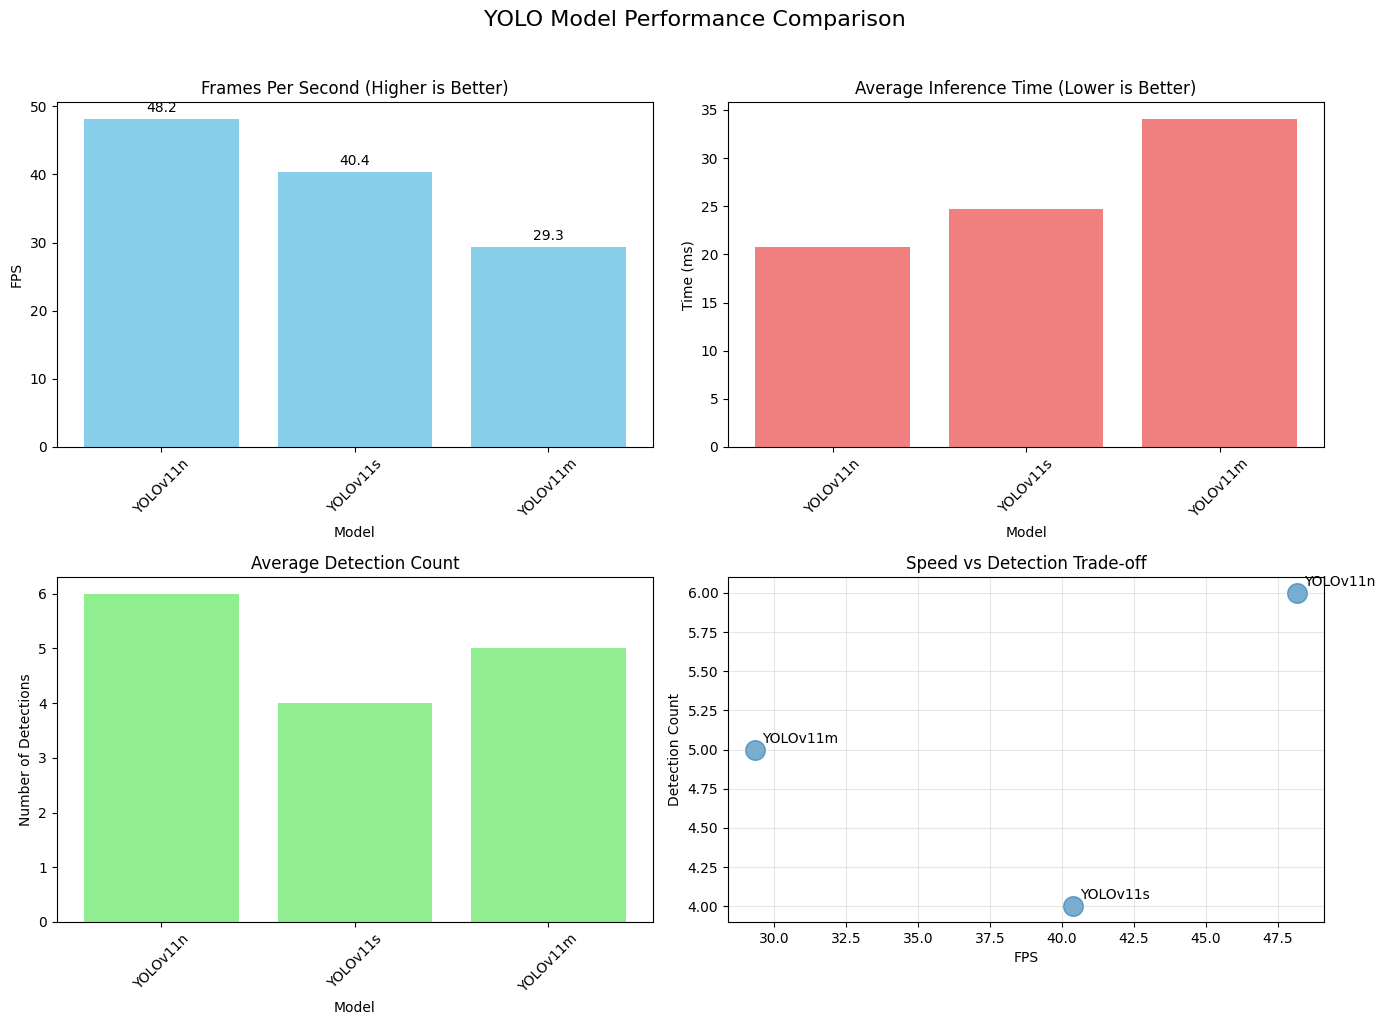


📋 성능 비교 요약:
   model  avg_time  std_time       fps  detections model_size
YOLOv11n  0.020763  0.000373 48.162339         6.0       3.2M
YOLOv11s  0.024753  0.002836 40.399458         4.0      11.2M
YOLOv11m  0.034076  0.000251 29.346106         5.0      25.9M

💡 모델 선택 가이드:
• 실시간 처리: YOLOv11n (최고 FPS)
• 최고 정확도: YOLOv11n (최다 검출)
• 균형잡힌 선택: YOLOv11n


In [10]:
class PerformanceBenchmark:
    """
    YOLO 모델 성능 벤치마크 도구
    """

    def __init__(self):
        self.results = []

    def benchmark_models(self, image_path, models_list):
        """
        여러 모델의 성능을 측정

        Parameters:
        -----------
        models_list : list
            [(model_name, model_path), ...]
        """
        print("🏁 성능 벤치마크 시작...\n")

        for model_name, model_path in tqdm(models_list, desc="모델 테스트"):
            try:
                # 모델 로드
                model = YOLO(model_path)

                # 워밍업 (첫 실행은 느림)
                _ = model(image_path, verbose=False)

                # 성능 측정 (5회 평균)
                times = []
                detections_counts = []

                for _ in range(5):
                    start_time = time.time()
                    results = model(image_path, verbose=False)
                    elapsed = time.time() - start_time
                    times.append(elapsed)

                    # 검출 수 계산
                    n_detections = 0
                    for r in results:
                        if r.boxes is not None:
                            n_detections += len(r.boxes)
                    detections_counts.append(n_detections)

                # 통계 계산
                avg_time = np.mean(times)
                std_time = np.std(times)
                fps = 1 / avg_time
                avg_detections = np.mean(detections_counts)

                # 모델 크기 정보
                model_size = self._get_model_size(model_name)

                self.results.append({
                    'model': model_name,
                    'avg_time': avg_time,
                    'std_time': std_time,
                    'fps': fps,
                    'detections': avg_detections,
                    'model_size': model_size
                })

            except Exception as e:
                print(f"⚠️ {model_name} 테스트 실패: {e}")

        return pd.DataFrame(self.results)

    def _get_model_size(self, model_name):
        """모델 크기 정보 반환"""
        sizes = {
            'YOLOv11n': '3.2M',
            'YOLOv11s': '11.2M',
            'YOLOv11m': '25.9M',
            'YOLOv11l': '43.7M',
            'YOLOv11x': '68.2M'
        }
        return sizes.get(model_name, 'Unknown')

    def visualize_results(self, df):
        """
        벤치마크 결과 시각화
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. FPS 비교
        axes[0, 0].bar(df['model'], df['fps'], color='skyblue')
        axes[0, 0].set_xlabel('Model')
        axes[0, 0].set_ylabel('FPS')
        axes[0, 0].set_title('Frames Per Second (Higher is Better)')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # FPS 값 표시
        for i, v in enumerate(df['fps']):
            axes[0, 0].text(i, v + 1, f'{v:.1f}', ha='center')

        # 2. 추론 시간 비교
        axes[0, 1].bar(df['model'], df['avg_time'] * 1000, color='lightcoral')
        axes[0, 1].set_xlabel('Model')
        axes[0, 1].set_ylabel('Time (ms)')
        axes[0, 1].set_title('Average Inference Time (Lower is Better)')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # 3. 검출 수 비교
        axes[1, 0].bar(df['model'], df['detections'], color='lightgreen')
        axes[1, 0].set_xlabel('Model')
        axes[1, 0].set_ylabel('Number of Detections')
        axes[1, 0].set_title('Average Detection Count')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # 4. 효율성 매트릭스 (속도 vs 검출)
        axes[1, 1].scatter(df['fps'], df['detections'], s=200, alpha=0.6)

        # 모델명 라벨 추가
        for idx, row in df.iterrows():
            axes[1, 1].annotate(row['model'],
                              (row['fps'], row['detections']),
                              xytext=(5, 5), textcoords='offset points')

        axes[1, 1].set_xlabel('FPS')
        axes[1, 1].set_ylabel('Detection Count')
        axes[1, 1].set_title('Speed vs Detection Trade-off')
        axes[1, 1].grid(True, alpha=0.3)

        plt.suptitle('YOLO Model Performance Comparison', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

        # 요약 테이블 출력
        print("\n📋 성능 비교 요약:")
        print(df.to_string(index=False))

        # 추천 사항
        print("\n💡 모델 선택 가이드:")
        fastest_model = df.loc[df['fps'].idxmax(), 'model']
        most_detections = df.loc[df['detections'].idxmax(), 'model']

        print(f"• 실시간 처리: {fastest_model} (최고 FPS)")
        print(f"• 최고 정확도: {most_detections} (최다 검출)")

        # 균형잡힌 모델 찾기 (FPS와 검출 수의 조화평균)
        df['efficiency'] = 2 * (df['fps'] / df['fps'].max()) * \
                          (df['detections'] / df['detections'].max()) / \
                          ((df['fps'] / df['fps'].max()) + \
                           (df['detections'] / df['detections'].max()))

        balanced_model = df.loc[df['efficiency'].idxmax(), 'model']
        print(f"• 균형잡힌 선택: {balanced_model}")

# 성능 벤치마크 실행
print("\n📊 모델 성능 비교 벤치마크")

benchmark = PerformanceBenchmark()

# 테스트할 모델 목록
test_models = [
    ('YOLOv11n', 'yolo11n.pt'),
    ('YOLOv11s', 'yolo11s.pt'),
    ('YOLOv11m', 'yolo11m.pt'),
]

if sample_images:
    # 벤치마크 실행
    results_df = benchmark.benchmark_models(sample_images[0], test_models)

    # 결과 시각화
    if not results_df.empty:
        benchmark.visualize_results(results_df)

## 🎯 Part 8: 실전 프로젝트 - 완성된 시스템

### 지금까지 배운 모든 기술을 통합한 실전 시스템

In [11]:
class IntegratedDetectionSystem:
    """
    통합 객체 검출 시스템
    모든 고급 기능을 하나로 결합
    """

    def __init__(self):
        print("🚀 통합 검출 시스템 초기화...")

        # 기본 검출기
        self.base_model = YOLO('yolo11m.pt')

        # 앙상블 검출기
        self.ensemble = EnsembleDetector([
            ('yolo11n.pt', 0.2),
            ('yolo11s.pt', 0.3),
            ('yolo11m.pt', 0.5)
        ])

        # 세그멘테이션 검출기
        self.segmentation = SegmentationDetector('yolo11n-seg.pt')

        # 검출 기록
        self.detection_history = []

        print("✅ 시스템 준비 완료")

    def detect(self, image_path, mode='auto', domain=None,
              save_results=True):
        """
        통합 검출 수행

        Parameters:
        -----------
        mode : str
            'fast', 'balanced', 'accurate', 'segmentation', 'auto'
        domain : str
            특정 도메인 지정 (선택사항)
        save_results : bool
            결과 저장 여부
        """
        print(f"\n🔍 검출 시작: {Path(image_path).name}")
        print(f"   모드: {mode}, 도메인: {domain or 'general'}")

        # 모드 자동 선택
        if mode == 'auto':
            mode = self._select_optimal_mode(image_path)

        # 모드별 검출 수행
        if mode == 'fast':
            results = self._fast_detection(image_path)
        elif mode == 'accurate':
            results = self._accurate_detection(image_path)
        elif mode == 'segmentation':
            results = self._segmentation_detection(image_path)
        else:  # balanced
            results = self._balanced_detection(image_path)

        # 도메인 특화 후처리
        if domain:
            results = self._apply_domain_filter(results, domain)

        # 결과 저장
        if save_results:
            self._save_results(image_path, results, mode, domain)

        # 기록 추가
        self.detection_history.append({
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'image': image_path,
            'mode': mode,
            'domain': domain,
            'detections': len(results.get('detections', []))
        })

        return results

    def _select_optimal_mode(self, image_path):
        """
        이미지 특성에 따라 최적 모드 자동 선택
        """
        # 이미지 크기 확인
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        # 이미지 크기에 따른 모드 선택
        if width * height > 1920 * 1080:
            return 'fast'  # 큰 이미지는 빠른 모드
        elif width * height < 640 * 480:
            return 'accurate'  # 작은 이미지는 정확한 모드
        else:
            return 'balanced'  # 중간 크기는 균형 모드

    def _fast_detection(self, image_path):
        """빠른 검출 (nano 모델)"""
        model = YOLO('yolo11n.pt')
        results = model(image_path, conf=0.5, verbose=False)
        return self._parse_results(results[0])

    def _balanced_detection(self, image_path):
        """균형잡힌 검출 (medium 모델)"""
        results = self.base_model(image_path, conf=0.45, verbose=False)
        return self._parse_results(results[0])

    def _accurate_detection(self, image_path):
        """정확한 검출 (앙상블)"""
        ensemble_results = self.ensemble.ensemble_detect(image_path)
        return {'detections': ensemble_results, 'mode': 'ensemble'}

    def _segmentation_detection(self, image_path):
        """세그멘테이션 검출"""
        seg_results = self.segmentation.segment_image(image_path)
        return {'detections': seg_results, 'mode': 'segmentation'}

    def _parse_results(self, results):
        """결과 파싱"""
        detections = []

        if results.boxes is not None:
            for box in results.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])

                detections.append({
                    'bbox': [float(x1), float(y1), float(x2), float(y2)],
                    'class': results.names[cls_id],
                    'confidence': conf
                })

        return {'detections': detections}

    def _apply_domain_filter(self, results, domain):
        """도메인 필터 적용"""
        # 도메인별 관심 클래스
        domain_classes = {
            'traffic': ['person', 'car', 'bus', 'truck', 'traffic light'],
            'indoor': ['person', 'chair', 'laptop', 'tv', 'couch'],
            'outdoor': ['person', 'bicycle', 'car', 'dog', 'bird']
        }

        if domain in domain_classes:
            target_classes = domain_classes[domain]
            filtered = [d for d in results['detections']
                       if d['class'] in target_classes]
            results['detections'] = filtered
            results['domain_filtered'] = True

        return results

    def _save_results(self, image_path, results, mode, domain):
        """결과 저장"""
        # 결과 폴더 생성
        output_dir = Path('detection_results')
        output_dir.mkdir(exist_ok=True)

        # 타임스탬프 추가
        timestamp = time.strftime('%Y%m%d_%H%M%S')
        base_name = Path(image_path).stem

        # JSON으로 저장
        json_path = output_dir / f"{base_name}_{timestamp}.json"
        with open(json_path, 'w') as f:
            json.dump({
                'image': str(image_path),
                'mode': mode,
                'domain': domain,
                'timestamp': timestamp,
                'results': results
            }, f, indent=2)

        print(f"   💾 결과 저장: {json_path}")

    def generate_report(self):
        """
        검출 기록 리포트 생성
        """
        if not self.detection_history:
            print("검출 기록이 없습니다.")
            return

        print("\n" + "="*50)
        print("📊 검출 시스템 리포트")
        print("="*50)

        df = pd.DataFrame(self.detection_history)

        print(f"\n총 검출 수행: {len(df)}회")
        print(f"평균 검출 객체 수: {df['detections'].mean():.1f}개")

        print("\n모드별 사용 빈도:")
        mode_counts = df['mode'].value_counts()
        for mode, count in mode_counts.items():
            print(f"  • {mode}: {count}회")

        print("\n최근 검출 기록:")
        for _, record in df.tail(3).iterrows():
            print(f"  {record['timestamp']}: {Path(record['image']).name} "
                 f"({record['detections']} objects)")

# 통합 시스템 테스트
print("\n🎯 통합 검출 시스템 테스트")

system = IntegratedDetectionSystem()

if sample_images:
    # 다양한 모드로 테스트
    test_configs = [
        ('fast', None),
        ('balanced', 'traffic'),
        ('accurate', None),
    ]

    for mode, domain in test_configs:
        results = system.detect(
            sample_images[0],
            mode=mode,
            domain=domain,
            save_results=True
        )
        print(f"   검출 완료: {len(results['detections'])} objects\n")

    # 리포트 생성
    system.generate_report()


🎯 통합 검출 시스템 테스트
🚀 통합 검출 시스템 초기화...
🔧 앙상블 검출기 초기화...
  • yolo11n.pt 로딩 (가중치: 0.2)
  • yolo11s.pt 로딩 (가중치: 0.3)
  • yolo11m.pt 로딩 (가중치: 0.5)
✅ 3개 모델로 앙상블 준비 완료
🎨 세그멘테이션 모델 로딩: yolo11n-seg.pt
✅ 세그멘테이션 모델 준비 완료
✅ 시스템 준비 완료

🔍 검출 시작: bus.jpg
   모드: fast, 도메인: general
   💾 결과 저장: detection_results/bus_20251121_024206.json
   검출 완료: 4 objects


🔍 검출 시작: bus.jpg
   모드: balanced, 도메인: traffic
   💾 결과 저장: detection_results/bus_20251121_024206.json
   검출 완료: 3 objects


🔍 검출 시작: bus.jpg
   모드: accurate, 도메인: general
   💾 결과 저장: detection_results/bus_20251121_024207.json
   검출 완료: 5 objects


📊 검출 시스템 리포트

총 검출 수행: 3회
평균 검출 객체 수: 4.0개

모드별 사용 빈도:
  • fast: 1회
  • balanced: 1회
  • accurate: 1회

최근 검출 기록:
  2025-11-21 02:42:06: bus.jpg (4 objects)
  2025-11-21 02:42:06: bus.jpg (3 objects)
  2025-11-21 02:42:07: bus.jpg (5 objects)


## 🎓 마무리 및 핵심 정리

### 📝 학습한 내용 정리

1. **YOLO11 기본**
   - 5가지 모델 크기 (nano ~ xlarge)
   - 속도와 정확도의 트레이드오프
   - GPU 활용법

2. **고급 기법**
   - **앙상블**: 여러 모델 결합으로 정확도 향상
   - **세그멘테이션**: 픽셀 단위 정밀 검출
   - **도메인 특화**: 특정 용도 최적화

3. **실무 응용**
   - 교통 모니터링
   - 보안 감시
   - 리테일 분석

### 💡 핵심 팁

```python
# 용도별 최적 설정
settings = {
    '실시간': {'model': 'yolo11n.pt', 'conf': 0.5},
    '균형': {'model': 'yolo11m.pt', 'conf': 0.45},
    '정확도': {'model': 'ensemble', 'conf': 0.4},
    '세밀함': {'model': 'yolo11x-seg.pt', 'conf': 0.5}
}
```

### 🚀 다음 단계

1. **커스텀 데이터셋 학습**
   - 자신만의 객체 클래스 정의
   - 데이터 라벨링
   - 모델 파인튜닝

2. **실시간 시스템 구축**
   - 웹캠 연동
   - 스트리밍 서버
   - 웹 인터페이스

3. **프로덕션 배포**
   - Docker 컨테이너화
   - API 서버 구축
   - 클라우드 배포

### 📚 추가 학습 자료

- [Ultralytics Documentation](https://docs.ultralytics.com/)
- [YOLO11 GitHub](https://github.com/ultralytics/ultralytics)
- [Computer Vision Course](https://www.coursera.org/learn/computer-vision-basics)

---

**작성자**: aebonlee  
**GitHub**: [YOLO11_study](https://github.com/aebonlee/YOLO11_study)  
**License**: MIT

질문이나 피드백은 GitHub Issues에 남겨주세요! 🎉

In [ ]:
# 노트북 완료 메시지
print("🎉 축하합니다! YOLO11 고급 튜토리얼을 완료했습니다!")
print("\n이제 당신은:")
print("✅ YOLO11의 다양한 모델을 활용할 수 있습니다")
print("✅ 앙상블과 세그멘테이션을 구현할 수 있습니다")
print("✅ 도메인 특화 검출 시스템을 구축할 수 있습니다")
print("✅ 성능 최적화를 수행할 수 있습니다")
print("\n🚀 이제 실제 프로젝트에 적용해보세요!")